In [194]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

In [195]:
distances = {'WD 0046+051':  4.3, 
'WD 1202-232':  10.4, 
'WD 1620-391':  12.9, 
'WD 2032+248':  14.8, 
'WD 1134+300':  15.7, 
'WD 2149+021':  22.5}

temperatures = {'WD 0046+051': 6400, 
'WD 1202-232':  8700, 
'WD 1620-391':  26200, 
'WD 2032+248':  20400, 
'WD 1134+300':  22000, 
'WD 2149+021':  18100}

In [196]:
spectrum_path = {'WD 0046+051': ('data/spec-57391-EG004455N031203M01_sp12-228.fits', 
                                 'https://ui.adsabs.harvard.edu/abs/2018yCat.5153....0L/abstract'),
                 'WD 1202-232': None, 
                 'WD 1620-391': ('data/hd147513.fits', 
                                 'https://ui.adsabs.harvard.edu/abs/2004A%26A...414..699C/abstract'),
                 'WD 1134+300': ('data/spec-57042-HD112918N302528M01_sp06-183.fits', 
                                 'https://ui.adsabs.harvard.edu/abs/2018yCat.5153....0L/abstract'), 
                 'WD 2149+021': ('data/spec-56957-EG214710N042410M01_sp07-226.fits', 
                                 'https://ui.adsabs.harvard.edu/abs/2018yCat.5153....0L/abstract'), 
                 'WD 2032+248': None}

sed_path = {'WD 0046+051': 'data/0046+051.vot', 
            'WD 1202-232': 'data/1202-232.vot', 
            'WD 1620-391': 'data/1620-391.vot', 
            'WD 2032+248': 'data/2032+248.vot', 
            'WD 2149+021': 'data/2149+021.vot', 
            'WD 1134+300': 'data/1134+300.vot'}

data = fits.getdata(path)
header = fits.getheader(path)

In [197]:
float(radius/(distances[key]*u.pc))

9.186673060518689e-12

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in greater
//anaconda3/lib/python3.7/site-packages/astropy-4.1.dev27126-py3.7-macosx-10.7-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in expm1
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
//anaconda3/lib/python3.7/site-packages/astropy-4.1.dev27126-py3.7-macosx-10.7-x86_64.egg/astropy/units/quantity.py:481: RuntimeWarning: overflow encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
//anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: UserWarning: Warning: converting a mask

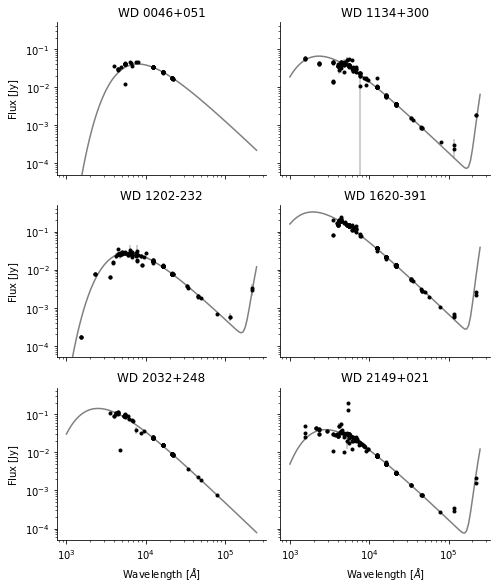

In [268]:
fig, ax = plt.subplots(3, 2, figsize=(7, 8), sharex=True, sharey=True)

from astropy.constants import R_earth

radius = R_earth


ir_excess = {'WD 0046+051': None, 
             'WD 1202-232': 42, 
             'WD 1620-391': 34, 
             'WD 2032+248': None, 
             'WD 2149+021': 38, 
             'WD 1134+300': 34}

wl_grid = np.logspace(np.log10(100), np.log10(25000), 100) * u.nm

for i, key in enumerate(sorted(sed_path.keys())): 

    t = Table.read(sed_path[key])

    wavelength = t['sed_freq'].quantity.to(u.Angstrom, u.spectral())
    sort = np.argsort(wavelength)
    
    blackbody = BlackBody1D(temperatures[key] * u.K)    
    bb = blackbody(wavelength[sort]).to(u.Jy).value
    wavelength_range = (wavelength[sort] < 5*u.um) & (wavelength[sort] > 1*u.um)
    y = t['sed_flux'].data.data[sort][wavelength_range]
    yerr = t['sed_eflux'].data.data[sort][wavelength_range]
    
    not_nan = ~np.isnan(yerr) & (yerr > 0)
    X = bb[wavelength_range][not_nan][:, None]
    inv_N = np.linalg.inv(np.identity(len(bb[wavelength_range][not_nan])) * yerr[not_nan]**2)

    # Solve linear regression: 
    betas = np.linalg.inv(X.T @ inv_N @ X) @ X.T @ inv_N @ y[not_nan]

    bb = blackbody(wl_grid).to(u.Jy).value

    axis = fig.axes[i]
    
    if ir_excess[key] is not None:
        bb_excess = BlackBody1D(ir_excess[key]*u.K)
        bb += bb_excess(wl_grid).to(u.Jy).value
    
    axis.errorbar(wavelength.to(u.Angstrom).value, t['sed_flux'], t['sed_eflux'], 
                  fmt='.', color='k', ecolor='silver')
    
    axis.plot(wl_grid.to(u.Angstrom).value, bb * betas[0], color='gray')
    
    axis.set_xscale('log')
    axis.set_yscale('log')
    axis.set_title(key)
    
    for s in ['right', 'top']:
        axis.spines[s].set_visible(False)
    if i % 2 == 0: 
        axis.set_ylabel('Flux [{0:latex}]'.format(t['sed_flux'].unit))
        
fig.tight_layout()
ax[-1, 0].set_xlabel('Wavelength [$\AA$]')
ax[-1, 1].set_xlabel('Wavelength [$\AA$]')
fig.savefig('plots/seds.pdf', bbox_inches='tight')